# <div align='center'>Bigbasket Product Categorization</div>

<div align='center'>Categorizing bigbasket products solely based on their description into 11 predefined categories.</div>

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import string
import re
import contractions
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
product = pd.read_csv('BigBasket Products.csv')
product.shape

(27555, 10)

In [3]:
product.head()

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


## Preprocessing

we only need description and category columns for classification

In [4]:
df =product[['category','description']]

In [5]:
df

,category,description
0,Beauty & Hygiene,This Product contains Garlic Oil that is known...
1,"Kitchen, Garden & Pets","Each product is microwave safe (without lid), ..."
2,Cleaning & Household,"A perfect gift for all occasions, be it your m..."
3,Cleaning & Household,Multipurpose container with an attractive desi...
4,Beauty & Hygiene,Nivea Creme Soft Soap gives your skin the best...
...,...,...
27550,Beauty & Hygiene,Layerr brings you Wottagirl Classic fragrant b...
27551,Gourmet & World Food,Puramate rosemary is enough to transform a dis...
27552,Gourmet & World Food,We have taken the richness of Sweet Potatoes (...
27553,Beverages,"Tetley Green Tea with its refreshing pure, ori..."


#### handling duplicate and missing values

In [6]:
df.duplicated().sum()

np.int64(5578)

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(21977, 2)

In [8]:
df.isna().sum()

category        0
description    10
dtype: int64

There are 10 missing values for description.   
This is insignificant number compared to dataset size. Thus these rows can be discarded.

In [9]:
df.dropna(subset='description', inplace=True)
df.shape

(21967, 2)

#### Ensuring correct data type

In [10]:
df.dtypes

category       object
description    object
dtype: object

#### outlier detection

For 'category' column

In [11]:
df['category'].unique()

array(['Beauty & Hygiene', 'Kitchen, Garden & Pets',
       'Cleaning & Household', 'Gourmet & World Food',
       'Foodgrains, Oil & Masala', 'Snacks & Branded Foods', 'Beverages',
       'Bakery, Cakes & Dairy', 'Baby Care', 'Fruits & Vegetables',
       'Eggs, Meat & Fish'], dtype=object)

It has 11 unique 'category' values in which none indicate outliers.

For 'description column'

Adding a length column to analyze length of descriptions

In [12]:
df['length'] = df['description'].apply(len)

Analysing length distribution

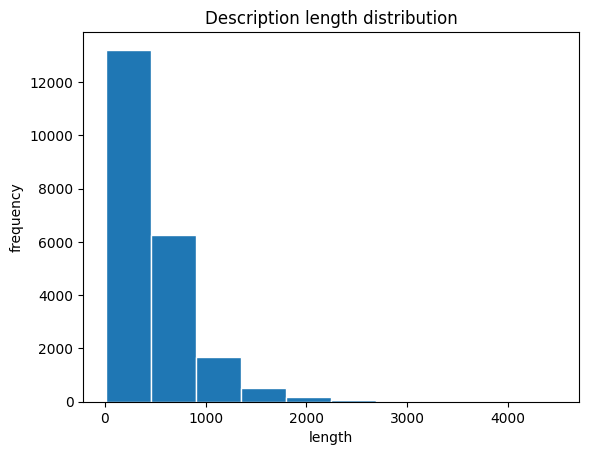

In [13]:
plt.hist(df['length'], edgecolor='white')
plt.title("Description length distribution")
plt.xlabel("length")
plt.ylabel("frequency")
plt.show()

Some description are of very small length(3-4 words) while very few go beyond 4000.

In [14]:
df[df['length']<20]

,category,description,length
80,Snacks & Branded Foods,Made with Topica,16
619,Cleaning & Household,Indian cloth clips,18
936,Snacks & Branded Foods,Made with Potato,16
2253,Gourmet & World Food,For Chips & Salsas,18
3618,Gourmet & World Food,Imported from UK,16
4339,"Bakery, Cakes & Dairy",Real Fruit Yoghurt,18
5056,Gourmet & World Food,Cookies,7
5386,Snacks & Branded Foods,Escape into One.,16
5512,Beverages,Organic Green Tea,17
6608,Snacks & Branded Foods,Made with Gramflour,19


A look at short length descriptions and one can tell that index 10012, 5386 are not very meaningful descriptions about a product.

In [15]:
df.drop(index=[5386, 10012], inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
df[df['length']>4000]

,category,description,length
288,Beauty & Hygiene,This basic mask sheet line that provides an ho...,4372
293,Gourmet & World Food,Swa Artisanal Syrups Lychee Lemon Syrup - Make...,4139
1190,Beauty & Hygiene,"Sunsilk Lusciously Thick & Long shampoo, for v...",4171
4627,Beauty & Hygiene,"""The Intimus Menstrual Cup is bell-shaped and ...",4210
5262,Beauty & Hygiene,"""The Intimus Menstrual Cup is bell shaped and ...",4204
6658,Gourmet & World Food,Swa Artisanal Syrups Mojito Mint Syrup - Makes...,4306
10339,Beverages,Shunya Go Zappy Apple - Active Hydration Drink...,4056
10937,Cleaning & Household,"Presenting, Surf excel matic front load the ma...",4486
15334,Cleaning & Household,Presenting new Surf Excel Matic Top Load Liqui...,4460
17751,Cleaning & Household,Harpic: Cleaning the toilet is often the most ...,4013


These descriptions look genuine. However, it's not possible to identify all outliers manually for a huge dataset

Identifing possible outliers using isolation forest

In [17]:
vect = TfidfVectorizer()
outlier_feature = vect.fit_transform(df['description'])

i_forest = IsolationForest(contamination=0.001, random_state=42)
outliers = i_forest.fit_predict(outlier_feature.toarray())
df['outlier'] = outliers==-1

In [18]:
outlier_df = df[df['outlier']==True].reset_index()

In [19]:
outlier_df

,index,category,description,length,outlier
0,752,Gourmet & World Food,Tea Profile: TE-A-ME brings the season's fine ...,2203,True
1,1697,Gourmet & World Food,Tea Profile: TE-A-ME brings the season's fine ...,2029,True
2,2083,Beauty & Hygiene,Stepping out without sun protection You think ...,1149,True
3,2239,Gourmet & World Food,"Chia Seeds: A gluten-free superseded, by natur...",1361,True
4,2752,Gourmet & World Food,Quinoa: Quinoa is considered to be the best in...,1171,True
5,3061,Gourmet & World Food,Graminway Barley Atta is made from finest barl...,1051,True
6,3347,Snacks & Branded Foods,Graminway Tropical Fruit Mix is a naturally sw...,1123,True
7,5749,"Foodgrains, Oil & Masala",Graminway Bhojpuri Masala is a spice mix used ...,960,True
8,5854,Snacks & Branded Foods,Graminway Raw Wild Honey is unheated and unpas...,1007,True
9,7302,Beauty & Hygiene,Vitamin C Face Toner With Vitamin C & Cucumber...,1961,True


In [20]:
df.drop('outlier', axis=1, inplace=True)

The possible predicted outliers are genuine descriptions. 

#### cleaning text by removing symbols, emoticons etc.

In [21]:
def clean_text(text):
    text= text.lower()
    text= re.sub(r'https?://\S+|www\.\S+', '', text)
    text = contractions.fix(text)
    text= ''.join([i for i in text if i not in string.punctuation])
    text= re.sub('/n','',text)
    text= re.sub(r'[^\w\s]', '', text)
    text= re.sub(r'\.{2,}', ' ', text)
    text= re.sub(r'[<>]', '', text)
    text = ''.join([i for i in text if not i.isdigit()])
    text= ' '.join(text.split())
    return text

In [22]:
df['description'] = df['description'].apply(clean_text)

#### Removing stopwords and performing lemmatization

In [23]:
stopword_list = stopwords.words('english')
lemma = WordNetLemmatizer()

def stopwords_lemma(text):
    tokens= word_tokenize(text)
    tokens= [i for i in tokens if i not in stopword_list]
    tokens= ' '.join(lemma.lemmatize(i) for i in tokens)
    return tokens

In [24]:
df['description'] = df['description'].apply(stopwords_lemma)

#### Vizualizing word Frequencies

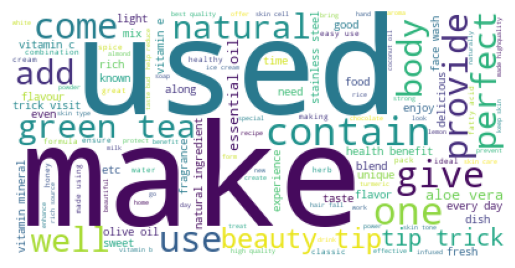

In [25]:
desc = ' '.join(df['description'].astype('str')) 

cloud = WordCloud(background_color='white').generate(desc)
plt.figure.figsize=(15,10)
plt.imshow(cloud)
plt.axis('off')
plt.show()

#### Separationg training and testing set

###### Class imbalance analysis

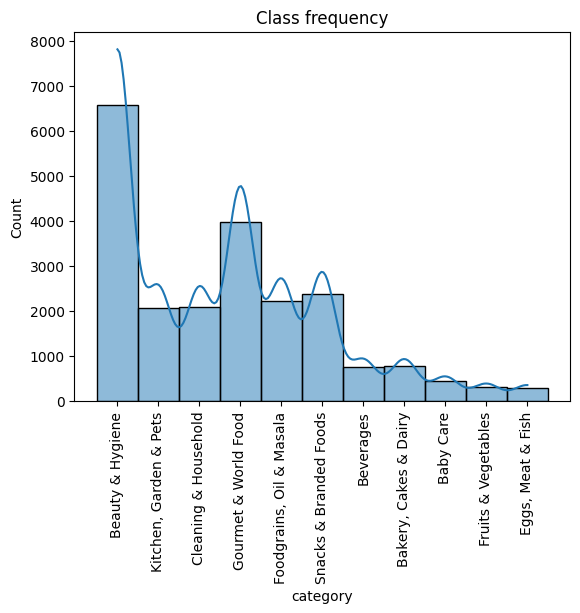

In [26]:
sns.histplot(df['category'], kde=True)
plt.xticks(rotation=90)
plt.title('Class frequency')
plt.show()

In [27]:
X = df['description']
y = df['category']

In [28]:

sss= StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for i, j in sss.split(X,y):
    X_train, X_test = X.iloc[i], X.iloc[j]
    y_train, y_test = y.iloc[i], y.iloc[j]

#### Vectorising features

In [29]:
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)

In [30]:
joblib.dump(vectorizer, 'tfidfvectorizer.pkl')

['tfidfvectorizer.pkl']

#### Resampling training set using hybrid approach

In [31]:
resampler = SMOTETomek()
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_vect, y_train)

#### Label Encoding

In [32]:
def labelencoder(y):
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    return y_encoded
    

In [33]:
y_train_join = labelencoder(y_train_resampled)

## Model Selection

Models will be trained using different algorithms and evaluated using cross validation.   
Hyper-parameters are selected with help of grid search.

### using Naive Bayes

In [34]:
param_grid = {'alpha': [0.1,0.01,0.001,0.0001,0.5,1.0,2.0,5.0,10.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_join)
print(f"best parameter : {grid_search.best_params_}")
print("Best Score:", grid_search.best_score_)

best parameter : {'alpha': 0.0001}
Best Score: 0.9754376639658686


##### Evaluating naive bayes

Creating functions to evaluate the model based on following :   

1. Accuracy
2. precision
3. recall
4. confusion matrix
5. f1 score

In [35]:
#function for cross validation score
def cvscore(model):
    cv = cross_val_score(model, X_train_resampled, y_train_join, cv=5, scoring='f1_macro', n_jobs=-1)
    print(cv)
    print(cv.mean())
    print(cv.std())

#function for cross validation prediction
def cvpredict(model):
    cv_pred = cross_val_predict(model, X_train_resampled, y_train_join, cv=5, n_jobs=-1)
    return cv_pred

# function for evaluation
def eval(pred):
    cm = confusion_matrix(y_train_join,pred)
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='d')
    plt.show()
    print(classification_report(y_train_join, pred))
    print(f'accuracy : {accuracy_score(y_train_join, pred)}')

In [36]:
model_nb= MultinomialNB(alpha= 0.0001)
cvscore(model_nb)

[0.96651382 0.96582751 0.97703612 0.98398402 0.98382686]
0.9754376639658686
0.007974507105028379


On a positive note, the cross validation scores do not hint at overfitting or underfitting.

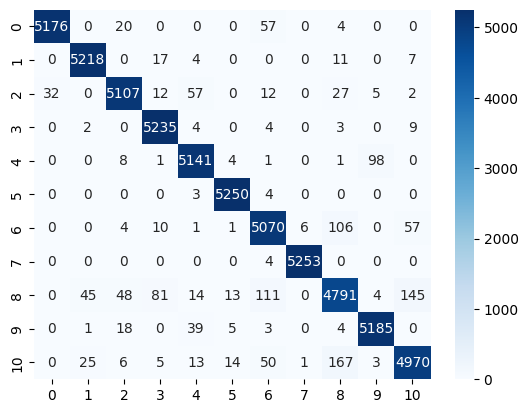

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5257
           1       0.99      0.99      0.99      5257
           2       0.98      0.97      0.98      5254
           3       0.98      1.00      0.99      5257
           4       0.97      0.98      0.98      5254
           5       0.99      1.00      1.00      5257
           6       0.95      0.96      0.96      5255
           7       1.00      1.00      1.00      5257
           8       0.94      0.91      0.92      5252
           9       0.98      0.99      0.98      5255
          10       0.96      0.95      0.95      5254

    accuracy                           0.98     57809
   macro avg       0.98      0.98      0.98     57809
weighted avg       0.98      0.98      0.98     57809

accuracy : 0.975557439153073


In [37]:
y_pred = cvpredict(model_nb)
eval(y_pred)

### Using logistic regression

In [38]:
model_lr = LogisticRegression(C=100, penalty='l2', solver='saga', max_iter=400)
cvscore(model_lr)

[0.97569376 0.97601766 0.98455401 0.99549088 0.99600475]
0.9855522101600721
0.008912079794916468


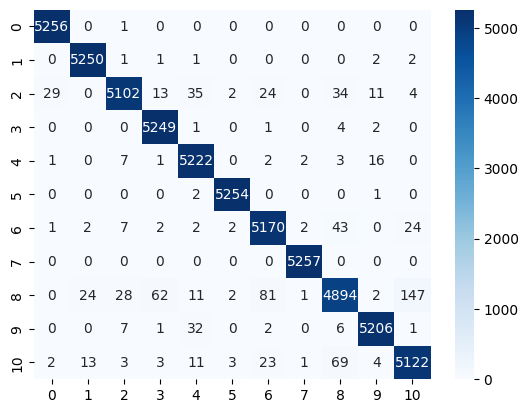

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5257
           1       0.99      1.00      1.00      5257
           2       0.99      0.97      0.98      5254
           3       0.98      1.00      0.99      5257
           4       0.98      0.99      0.99      5254
           5       1.00      1.00      1.00      5257
           6       0.97      0.98      0.98      5255
           7       1.00      1.00      1.00      5257
           8       0.97      0.93      0.95      5252
           9       0.99      0.99      0.99      5255
          10       0.97      0.97      0.97      5254

    accuracy                           0.99     57809
   macro avg       0.99      0.99      0.99     57809
weighted avg       0.99      0.99      0.99     57809

accuracy : 0.9856942690584511


In [39]:
y_pred = cvpredict(model_lr)
eval(y_pred)

### using Random Forest Classifier

In [41]:
model_rf = RandomForestClassifier(n_estimators=300, criterion='entropy', random_state= 42)
cvscore(model_rf)

[0.94567645 0.96229666 0.97881154 0.9922701  0.99340595]
0.9744921383450652
0.018283977564878023


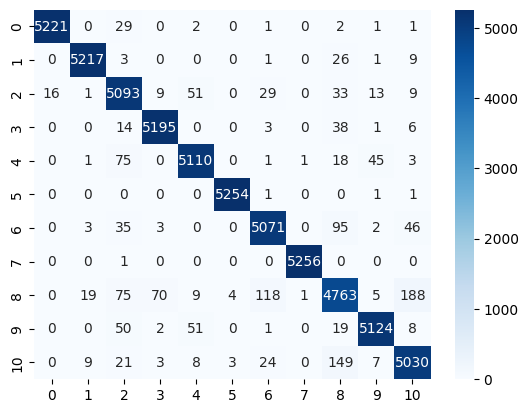

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5257
           1       0.99      0.99      0.99      5257
           2       0.94      0.97      0.96      5254
           3       0.98      0.99      0.99      5257
           4       0.98      0.97      0.97      5254
           5       1.00      1.00      1.00      5257
           6       0.97      0.96      0.97      5255
           7       1.00      1.00      1.00      5257
           8       0.93      0.91      0.92      5252
           9       0.99      0.98      0.98      5255
          10       0.95      0.96      0.95      5254

    accuracy                           0.97     57809
   macro avg       0.97      0.97      0.97     57809
weighted avg       0.97      0.97      0.97     57809

accuracy : 0.9744849417910706


In [42]:
y_predict = cvpredict(model_rf)
eval(y_predict)

### Using Support Vector Machine (SVM)

In [43]:
model_svc = SVC(random_state=42, C=10)
cvscore(model_svc)

[0.97626607 0.98197619 0.98922999 0.99627541 0.99610005]
0.9879695416010849
0.00786857964654836


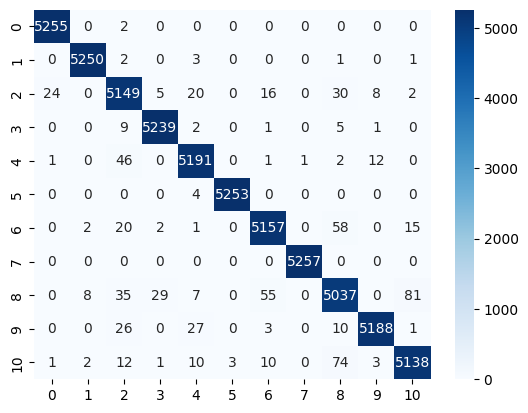

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5257
           1       1.00      1.00      1.00      5257
           2       0.97      0.98      0.98      5254
           3       0.99      1.00      0.99      5257
           4       0.99      0.99      0.99      5254
           5       1.00      1.00      1.00      5257
           6       0.98      0.98      0.98      5255
           7       1.00      1.00      1.00      5257
           8       0.97      0.96      0.96      5252
           9       1.00      0.99      0.99      5255
          10       0.98      0.98      0.98      5254

    accuracy                           0.99     57809
   macro avg       0.99      0.99      0.99     57809
weighted avg       0.99      0.99      0.99     57809

accuracy : 0.9879776505388435


In [44]:
y_predict = cvpredict(model_svc)
eval(y_predict)

The SVC model performs well on all classes. 

### Fitting the selected model : SVC

In [45]:
model_svc.fit(X_train_resampled, y_train_join)

SVC(C=10, random_state=42)

In [46]:
joblib.dump(model_svc, 'svcmodel.pkl')

['svcmodel.pkl']

## Model Evaluation on test set

In [47]:
X_testing = vectorizer.transform(X_test)
y_testing = labelencoder(y_test)

In [48]:
y_pred = model_svc.predict(X_testing)

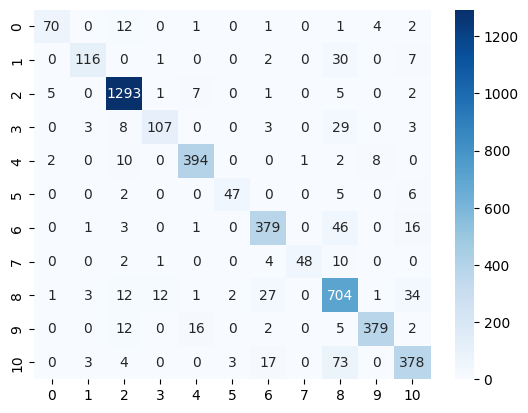

              precision    recall  f1-score   support

           0       0.90      0.77      0.83        91
           1       0.92      0.74      0.82       156
           2       0.95      0.98      0.97      1314
           3       0.88      0.70      0.78       153
           4       0.94      0.94      0.94       417
           5       0.90      0.78      0.84        60
           6       0.87      0.85      0.86       446
           7       0.98      0.74      0.84        65
           8       0.77      0.88      0.82       797
           9       0.97      0.91      0.94       416
          10       0.84      0.79      0.81       478

    accuracy                           0.89      4393
   macro avg       0.90      0.83      0.86      4393
weighted avg       0.89      0.89      0.89      4393

accuracy : 0.8911905303892557


In [49]:
cm = confusion_matrix(y_testing,y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d')
plt.show()
print(classification_report(y_testing, y_pred))
print(f'accuracy : {accuracy_score(y_testing, y_pred)}')

The cross-validation scores indicate that the model is not overfitting. The test set maintains the original class imbalance, which could explain the comparatively lower performance on the test set compared to the training set. Despite this, the model performs well given the class ratios. The lower scores are primarily for classes with very few test samples (e.g., class 5 has only 60 samples). Conversely, classes with a sufficient number of samples (e.g., class 2) demonstrate good performance.

Overall, the model shows strong performance.